# Play with feature importance

Three questions to answer in here: 
    
(1) Is there anything interesting SHAP can tell use? 

(2) Is the importance the same for the surrogate models and the ones trained on a larger training set? The same for Gibbs and virial? 

(3) Does is change over the course of the PAL?

In [1]:
import sys 
import os 
from pathlib import Path 
import numpy as np 

%load_ext autoreload
%autoreload 2

import pandas as pd
import shap 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'

DATADIR = '../data'
TRAIN_SIZE = 0.9

In [11]:
feat_names = list(pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).columns)

In [2]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([rg.reshape(-1,1), gibbs.reshape(-1,1)])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, y, train_size=TRAIN_SIZE)

vt = VarianceThreshold(0)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

feat_scaler = StandardScaler()
X_train = feat_scaler.fit_transform(X_train)
X_test = feat_scaler.transform(X_test)

In [4]:
def plot_parity(y_true, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_true, y_pred)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75,  zorder=0)
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$\hat{y}$')
    fig.tight_layout()


In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train[:,1])

xgb_rg = XGBRegressor()
xgb_rg.fit(X_train, y_train[:,0])

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [14]:
predictions = xgb.predict(X_test)
predictions_rg = xgb_rg.predict(X_test)


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


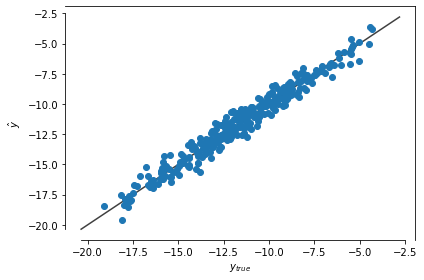

In [7]:
plot_parity(predictions, y_test[:,1])

In [8]:
explainer = shap.TreeExplainer(xgb)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [9]:
shap_values = explainer.shap_values(X_train, y_train)

not enough data in bin #6 for feature max_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #12 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #14 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #17 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.


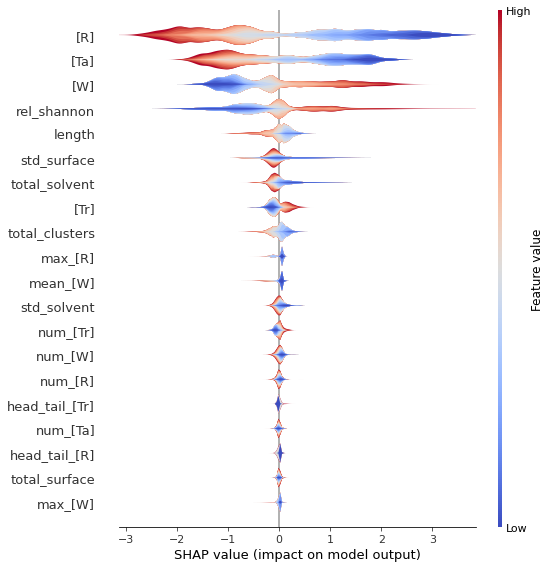

In [12]:
shap.summary_plot(shap_values, X_train, feature_names=feat_names, plot_type='layered_violin')

not enough data in bin #5 for feature min_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #11 for feature mean_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #15 for feature mean_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature mean_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #13 for feature mean_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #16 for feature mean_[Ta], so it'll be ignored. Try increasing the number of records to plot.


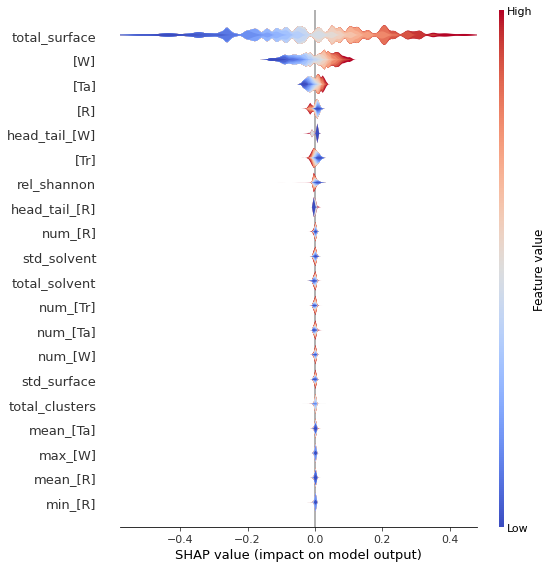

In [15]:
explainer_rg = shap.TreeExplainer(xgb_rg)
shap_values_rg = explainer_rg.shap_values(X_train, y_train)
shap.summary_plot(shap_values_rg, X_train, feature_names=feat_names, plot_type='layered_violin')